In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS,add_constant 
import statsmodels.api as sm

In [2]:
##Data loading

brent = yf.download('BZ=F',start='2015-01-01',end='2025-01-01',auto_adjust=True)['Close']
wti = yf.download('CL=F',start='2015-01-01',end='2025-01-01',auto_adjust=True)['Close']
data = pd.concat([brent,wti],axis=1,keys=['Brent','WTI'])
data = data.fillna(data.mean(numeric_only=True))
data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Brent,WTI
Ticker,BZ=F,CL=F
Date,,
2015-01-02,56.419998,52.689999
2015-01-05,53.110001,50.040001
2015-01-06,51.099998,47.930000
2015-01-07,51.150002,48.650002
2015-01-08,50.959999,48.790001
...,...,...
2024-12-24,73.580002,70.099998
2024-12-26,73.260002,69.620003


In [3]:
##corelation 
correlation = data[('Brent', 'BZ=F')].corr(data[('WTI', 'CL=F')])
print(f"Correlation between Brent and WTI: {correlation:.4f}")

Correlation between Brent and WTI: 0.9899


In [4]:
##Regression for hegde fund ratio

X = add_constant(data[('WTI', 'CL=F')])
model = OLS(data[('Brent', 'BZ=F')],X).fit()
beta,intercepters = model.params.get(('WTI', 'CL=F')),model.params.get('const')


In [5]:
##Calculate the spread
data['Spread'] = data[('Brent', 'BZ=F')] - (beta*data[('WTI', 'CL=F')]+intercepters)

data

,Brent,WTI,Spread
Ticker,BZ=F,CL=F,
Date,,,
2015-01-02,56.419998,52.689999,-0.616458
2015-01-05,53.110001,50.040001,-1.254675
2015-01-06,51.099998,47.930000,-1.137332
2015-01-07,51.150002,48.650002,-1.813249
2015-01-08,50.959999,48.790001,-2.144401
...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564
2024-12-26,73.260002,69.620003,-0.845622


In [6]:
print(beta)
print(intercepters)

1.008219985076435
3.9133463473994072


In [7]:
##Rolling Statistics and Z-scores
rolling_window = 252

data[('Spread_Mean','')] = data[('Spread','')].rolling(rolling_window).mean()
data[('Spread_Std','')] = data[('Spread','')].rolling(rolling_window).std()
data[('Spread_z','')] = (data[('Spread','')] - data[('Spread_Mean','')]) / data[('Spread_Std','')]

data

,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z
Ticker,BZ=F,CL=F,,,,
Date,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,NaN,NaN,NaN
2015-01-05,53.110001,50.040001,-1.254675,NaN,NaN,NaN
2015-01-06,51.099998,47.930000,-1.137332,NaN,NaN,NaN
2015-01-07,51.150002,48.650002,-1.813249,NaN,NaN,NaN
2015-01-08,50.959999,48.790001,-2.144401,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584


In [8]:
##signal Generating
volatility_filter = 0.5

data[('Valid_Signal','')] = abs(data[('Spread','')].diff())>volatility_filter
data[('Long_Signal','')] = (data[('Spread_z','')]<-2) & data[('Valid_Signal','')]
data[('Short_Signal','')] = (data[('Spread_z','')]>2) & data[('Valid_Signal','')]
data[('Close_Signal','')] = (data[('Spread_z','')]<0.5) & (data[('Spread_z','')]>-0.5)

data

,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z,Valid_Signal,Long_Signal,Short_Signal,Close_Signal
Ticker,BZ=F,CL=F,,,,,,,,
Date,,,,,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,NaN,NaN,NaN,False,False,False,False
2015-01-05,53.110001,50.040001,-1.254675,NaN,NaN,NaN,True,False,False,False
2015-01-06,51.099998,47.930000,-1.137332,NaN,NaN,NaN,False,False,False,False
2015-01-07,51.150002,48.650002,-1.813249,NaN,NaN,NaN,True,False,False,False
2015-01-08,50.959999,48.790001,-2.144401,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974,False,False,False,False
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584,False,False,False,False


In [9]:
##Rules for exit , entry as well as the holding period

data[('Positions','')]=0.0
holding_period = 5

##Position Simulations

for i in range(1,len(data)):
    if data[('Long_Signal','')].iloc[i]:
        data.loc[data.index[i],('Positions','')] =1.0
    elif data[('Short_Signal','')].iloc[i]:
        data.loc[data.index[i],('Positions','')] =-1.0
    elif data[('Close_Signal','')].iloc[i]:
        data.loc[data.index[i],('Positions','')] =0.0
    else:
        data.loc[data.index[i],('Positions','')] =data.loc[data.index[i-1],('Positions','')]
        

data

,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z,Valid_Signal,Long_Signal,Short_Signal,Close_Signal,Positions
Ticker,BZ=F,CL=F,,,,,,,,,
Date,,,,,,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,NaN,NaN,NaN,False,False,False,False,0.0
2015-01-05,53.110001,50.040001,-1.254675,NaN,NaN,NaN,True,False,False,False,0.0
2015-01-06,51.099998,47.930000,-1.137332,NaN,NaN,NaN,False,False,False,False,0.0
2015-01-07,51.150002,48.650002,-1.813249,NaN,NaN,NaN,True,False,False,False,0.0
2015-01-08,50.959999,48.790001,-2.144401,NaN,NaN,NaN,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974,False,False,False,False,0.0
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584,False,False,False,False,0.0


In [10]:
##Dynamic Positioning 
data[('Spread_Change')] = data[('WTI', 'CL=F')].diff() - data[('Brent', 'BZ=F')].diff()
trailing_stop_loss = 0.02
data[('PnL','')] = data[('Positions', '')].shift(1)*data[('Spread_Change')]
data[('PnL','')] = np.where(data[('PnL','')]<-trailing_stop_loss,-trailing_stop_loss,data[('PnL','')])

#Transaction Costs and Net PnL
transaction_cost_per_unit = 0.01
data[('Transaction_Cost','')] = abs(data[('Positions', '')].diff())*transaction_cost_per_unit
data[('Net_PnL','')] = data[('PnL','')]-data[('Transaction_Cost','')]
data[('Cumulative_Net_PnL')] = data[('Net_PnL','')] .cumsum()


##Key metrics

total_net_return = data[('Cumulative_Net_PnL')].iloc[-1]
sharpe_ratio = (data[('Net_PnL','')].mean()/data[('Net_PnL','')].std())*np.sqrt(252)

print(f"Total Net Return:{total_net_return:.2f}")
print(f"Sharpe Ratio:{sharpe_ratio:.2f}")

data

Total Net Return:141.40
Sharpe Ratio:0.83


,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z,Valid_Signal,Long_Signal,Short_Signal,Close_Signal,Positions,Spread_Change,PnL,Transaction_Cost,Net_PnL,Cumulative_Net_PnL
Ticker,BZ=F,CL=F,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,NaN,NaN,NaN,False,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,53.110001,50.040001,-1.254675,NaN,NaN,NaN,True,False,False,False,0.0,0.660000,0.0,0.0,0.0,0.000000
2015-01-06,51.099998,47.930000,-1.137332,NaN,NaN,NaN,False,False,False,False,0.0,-0.099998,-0.0,0.0,-0.0,0.000000
2015-01-07,51.150002,48.650002,-1.813249,NaN,NaN,NaN,True,False,False,False,0.0,0.669998,0.0,0.0,0.0,0.000000
2015-01-08,50.959999,48.790001,-2.144401,NaN,NaN,NaN,False,False,False,False,0.0,0.330002,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974,False,False,False,False,0.0,-0.090004,-0.0,0.0,-0.0,141.399922
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584,False,False,False,False,0.0,-0.159996,-0.0,0.0,-0.0,141.399922


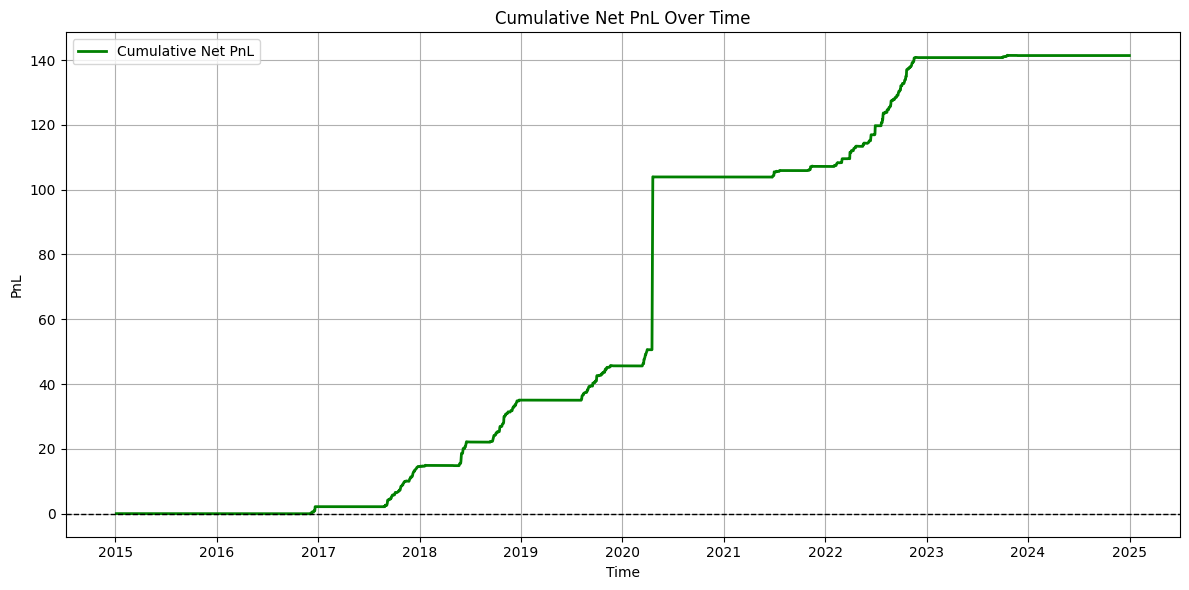

In [11]:


plt.figure(figsize=(12, 6))

# Plot the cumulative net PnL
plt.plot(data[('Cumulative_Net_PnL', '')], label='Cumulative Net PnL', color='green', linewidth=2)

# Add reference line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Plot settings
plt.title('Cumulative Net PnL Over Time')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


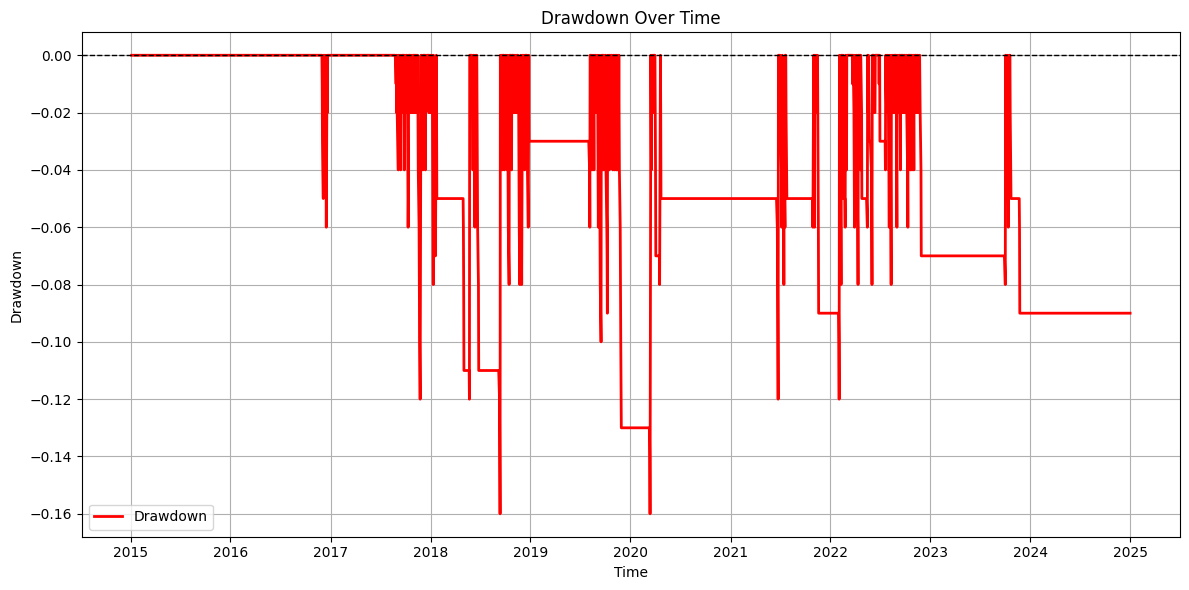

In [12]:
##Drawdown plot:
# Calculate running max of cumulative net PnL
data[('Running_Max_PnL', '')] = data[('Cumulative_Net_PnL', '')].cummax()

# Drawdown = current cumulative PnL - max cumulative PnL so far
data[('Drawdown', '')] = data[('Cumulative_Net_PnL', '')] - data[('Running_Max_PnL', '')]


plt.figure(figsize=(12, 6))

# Plot drawdown
plt.plot(data[('Drawdown', '')], label='Drawdown', color='red', linewidth=2)

# Add horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Plot settings
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [13]:

data

,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z,Valid_Signal,Long_Signal,Short_Signal,Close_Signal,Positions,Spread_Change,PnL,Transaction_Cost,Net_PnL,Cumulative_Net_PnL,Running_Max_PnL,Drawdown
Ticker,BZ=F,CL=F,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,NaN,NaN,NaN,False,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,53.110001,50.040001,-1.254675,NaN,NaN,NaN,True,False,False,False,0.0,0.660000,0.0,0.0,0.0,0.000000,0.000000,0.00
2015-01-06,51.099998,47.930000,-1.137332,NaN,NaN,NaN,False,False,False,False,0.0,-0.099998,-0.0,0.0,-0.0,0.000000,0.000000,0.00
2015-01-07,51.150002,48.650002,-1.813249,NaN,NaN,NaN,True,False,False,False,0.0,0.669998,0.0,0.0,0.0,0.000000,0.000000,0.00
2015-01-08,50.959999,48.790001,-2.144401,NaN,NaN,NaN,False,False,False,False,0.0,0.330002,0.0,0.0,0.0,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974,False,False,False,False,0.0,-0.090004,-0.0,0.0,-0.0,141.399922,141.489922,-0.09
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584,False,False,False,False,0.0,-0.159996,-0.0,0.0,-0.0,141.399922,141.489922,-0.09


In [14]:
data = data.fillna(data.mean(numeric_only=True))
data

,Brent,WTI,Spread,Spread_Mean,Spread_Std,Spread_z,Valid_Signal,Long_Signal,Short_Signal,Close_Signal,Positions,Spread_Change,PnL,Transaction_Cost,Net_PnL,Cumulative_Net_PnL,Running_Max_PnL,Drawdown
Ticker,BZ=F,CL=F,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2015-01-02,56.419998,52.689999,-0.616458,-0.024815,1.777136,0.027028,False,False,False,False,0.0,0.000322,0.056396,0.000151,0.056245,66.046716,66.086605,-0.039889
2015-01-05,53.110001,50.040001,-1.254675,-0.024815,1.777136,0.027028,True,False,False,False,0.0,0.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-06,51.099998,47.930000,-1.137332,-0.024815,1.777136,0.027028,False,False,False,False,0.0,-0.099998,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
2015-01-07,51.150002,48.650002,-1.813249,-0.024815,1.777136,0.027028,True,False,False,False,0.0,0.669998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-08,50.959999,48.790001,-2.144401,-0.024815,1.777136,0.027028,False,False,False,False,0.0,0.330002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,73.580002,70.099998,-1.009564,-0.435336,0.806529,-0.711974,False,False,False,False,0.0,-0.090004,-0.000000,0.000000,-0.000000,141.399922,141.489922,-0.090000
2024-12-26,73.260002,69.620003,-0.845622,-0.442523,0.802054,-0.502584,False,False,False,False,0.0,-0.159996,-0.000000,0.000000,-0.000000,141.399922,141.489922,-0.090000
